This notebook is a beginning into Diagnostics.
* split train into train, cross_validation, test - 60%/20%/20%
* create multiple models
* assess cross validation accuracy
* pick the configuration with the lowest cv loss
* assess accuracy on a test set
* comparison mean squared error for
    * numpy linear regression
    * numpy polynomial regression
    * tensorflow regression

In [34]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Regression
* linear
* non-linear, polynom

Load data

In [35]:
data = np.loadtxt("./data_w3_ex1.csv", delimiter=",")
x = data[:,0]
y = data[:,1]
x.shape, y.shape

((50,), (50,))

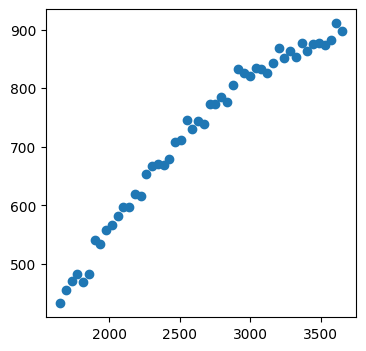

In [36]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x,y)
plt.show()

Split data into train, validate, test

* ***training set*** - used to train the model
* ***cross validation set (also called validation, development, or dev set)*** - used to evaluate the different model configurations you are choosing from. For example, you can use this to make a decision on what polynomial features to add to your dataset.
* ***test set*** - used to give a fair estimate of your chosen model's performance against new examples. This should not be used to make decisions while you are still developing the models.

x_train.shape - (30,), y_train.shape - (30,)       
x_val.shape - (10,), y_val.shape - (10,)       
x_test.shape - (10,), y_test.shape - (10,)


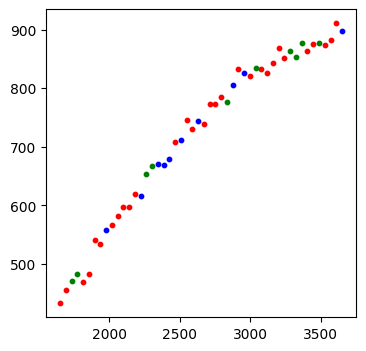

In [37]:
x_train, x_, y_train, y_ = train_test_split(x,y,test_size=0.4,shuffle=True)
x_val, x_test, y_val, y_test = train_test_split(x_,y_,test_size=0.5)

print(f"x_train.shape - {x_train.shape}, y_train.shape - {y_train.shape} \
      \nx_val.shape - {x_val.shape}, y_val.shape - {y_val.shape} \
      \nx_test.shape - {x_test.shape}, y_test.shape - {y_test.shape}")

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x_train, y_train, c='r', s = 10)
ax.scatter(x_val, y_val, c='g', s = 10)
ax.scatter(x_test, y_test, c='b', s = 10)

# Scaling

[`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class from scikit-learn. This computes the z-score of your inputs. As a refresher, the z-score is given by the equation:

$$ z = \frac{x - \mu}{\sigma} $$

where $\mu$ is the mean of the feature values and $\sigma$ is the standard deviation.

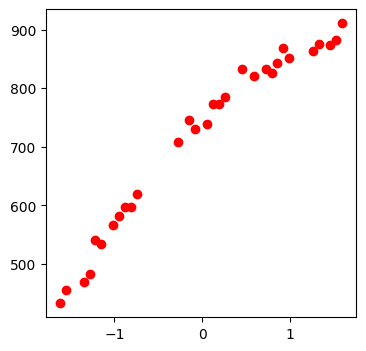

In [38]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 1))
x_val_scaled = scaler.transform(x_val.reshape(-1, 1))
x_test_scaled = scaler.transform(x_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x_train_scaled,y_train, c='r')
plt.show()

# SKLearn - Linear regression

Linear model

In [39]:
model = LinearRegression().fit(x_train_scaled,y_train)
model.coef_, model.intercept_

(array([145.58783102]), 713.5640446633624)

To evaluate the performance of your model, you will measure the error for the training and cross validation sets. For the training error, recall the equation for calculating the mean squared error (MSE):

$$J_{train}(\vec{w}, b) = \frac{1}{2m_{train}}\left[\sum_{i=1}^{m_{train}}(f_{\vec{w},b}(\vec{x}_{train}^{(i)}) - y_{train}^{(i)})^2\right]$$

Scikit-learn also has a built-in [`mean_squared_error()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) function that you can use. Take note though that [as per the documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error), scikit-learn's implementation only divides by `m` and not `2*m`, where `m` is the number of examples. As mentioned in Course 1 of this Specialization (cost function lectures), dividing by `2m` is a convention we will follow but the calculations should still work whether or not you include it. Thus, to match the equation above, you can use the scikit-learn function then divide by 2 as shown below. We also included a for-loop implementation so you can check that it's equal. 

Another thing to take note: Since you trained the model on scaled values (i.e. using the z-score), you should also feed in the scaled training set instead of its raw values.

In [40]:
prediction = model.predict(x_val_scaled)

diff_sq = (y_val - prediction) ** 2 
loss = np.sum(diff_sq) / len(y_val) / 2

print(f"Manually calculated loss = {loss}")
print(f"Single variable model - MSE validation = {mean_squared_error(y_val, prediction) / 2}")

Manually calculated loss = 311.8777657609151
Single variable model - MSE validation = 311.8777657609151


Testing

In [41]:
prediction = model.predict(x_test_scaled)
print(f"Single variable model - MSE test = {mean_squared_error(y_test,prediction) / 2}")

Single variable model - MSE test = 445.1947484501955


# SKLearn - Polynomial regression (>1 dim)

<img src='./images/C2_W3_poly.png' width=300 height=100>

You'll notice that the MSEs are significantly better for both the training and cross validation set when you added the 2nd order polynomial. You may want to introduce more polynomial terms and see which one gives the best performance. As shown in class, you can have 10 different models like this:

In [42]:
cost_train = np.zeros(10)
cost_val = np.zeros(10)

for i in range(10):
    poly = PolynomialFeatures(i)
    x_train_poly = poly.fit_transform(x_train_scaled.reshape(-1,1)) # add 1 more dimension to train and val set
    x_val_poly = poly.transform(x_val_scaled.reshape(-1,1))

    model = LinearRegression() # run linear regression model
    model.fit(x_train_poly, y_train)

    prediction = model.predict(x_val_poly) # MES (mean suqared error) for valuation set
    cost_val[i] = mean_squared_error(prediction, y_val) / 2

    prediction = model.predict(x_train_poly) # MES (mean suqared error) for train set
    cost_train[i] = mean_squared_error(prediction, y_train) / 2

print(f"Validation Loss for multi dim model: {cost_val}")

Validation Loss for multi dim model: [11589.56197318   311.87776576    44.20137311    44.5847068
    45.74186863    49.23462055    61.35845004    61.11937617
    80.76946115    73.35203069]


When selecting a model, you want to choose one that performs well both on the training and cross validation set. It implies that it is able to learn the patterns from your training set without overfitting. If you used the defaults in this lab, you will notice a sharp drop in cross validation error from the models with degree=1 to degree=2. This is followed by a relatively flat line up to degree=5. After that, however, the cross validation error is generally getting worse as you add more polynomial features. Given these, you can decide to use the model with the lowest cv_mse as the one best suited for your application.

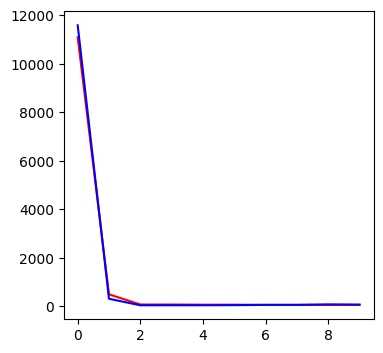

In [43]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(cost_train, c='r')
ax.plot(cost_val, c='b')
plt.show()

In [44]:
optimal_dim = np.argmin(cost_val)
print(f"Optimum dimensions for Linear model = {optimal_dim}")

Optimum dimensions for Linear model = 2


Calculate Test accuracy

In [45]:
x_test_scaled = scaler.transform(x_test.reshape(-1, 1))

poly = PolynomialFeatures(optimal_dim)
x_train_poly = poly.fit_transform(x_train_scaled)
x_test_poly = poly.fit_transform(x_test_scaled)

model = LinearRegression()
model.fit(x_train_poly,y_train)

prediction = model.predict(x_test_poly)
error = mean_squared_error(y_test,prediction)
accuracy = 1 - np.sum(np.abs((prediction-y_test))/y_test)

print(f"Test error MSE = {error}, and test accuracy = {accuracy} on dim 2 Polynom model")


Test error MSE = 98.38181314476296, and test accuracy = 0.878582753321558 on dim 2 Polynom model


# Tensorflow NN - Linear regression

The same model selection process can also be used when choosing between different neural network architectures. In this section, the models apply it to the same regression task above.

<img src='images/C2_W3_NN_Arch.png' width=300 height=300>

In [46]:
def build_models(input_shape=(1,)):

    model_1 = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.Dense(units = 25, activation="relu", name="L1"),
        tf.keras.layers.Dense(units = 15, activation="relu", name="L2"),
        tf.keras.layers.Dense(units = 1, activation="linear", name="output"),
    ])

    model_2 = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.Dense(units = 20, activation="relu", name="L1"),
        tf.keras.layers.Dense(units = 12, activation="relu", name="L2"),
        tf.keras.layers.Dense(units = 12, activation="relu", name="L3"),
        tf.keras.layers.Dense(units = 20, activation="relu", name="L4"),
        tf.keras.layers.Dense(units = 1, activation="linear", name="output"),
    ])

    model_3 = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.Dense(units = 32, activation="relu", name="L1"),
        tf.keras.layers.Dense(units = 16, activation="relu", name="L2"),
        tf.keras.layers.Dense(units = 8, activation="relu", name="L3"),
        tf.keras.layers.Dense(units = 4, activation="relu", name="L4"),
        tf.keras.layers.Dense(units = 12, activation="relu", name="L5"),
        tf.keras.layers.Dense(units = 1, activation="linear", name="output"),
    ])

    models = [model_1, model_2, model_3]

    return models

In [47]:
models = build_models(input_shape=(1,))
models_qty = len(models)

mse_models = np.zeros(models_qty)

for i in range(models_qty):

    model = models[i]

    model.compile(
        loss = tf.keras.losses.mean_squared_error,
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    )

    model.fit(x_train_scaled, y_train,
              epochs=300,
              verbose=0)

    prediction = model.predict(x_val_scaled)
    mse_models[i] = mean_squared_error(y_val, prediction) / 2

mse_models
    

1/1 [==============================] - 0s 90ms/step


array([311.87746274, 311.87738063,  74.37965503])

Calculate test error

In [48]:
best_model_idx = np.argmin(mse_models)
model = models[best_model_idx]

prediction = model.predict(x_test_scaled)
mse = mean_squared_error(y_test,prediction) / 2

print(f"Test MSE for {best_model_idx+1} model = {mse}")

1/1 [==============================] - 0s 39ms/step
Test MSE for 3 model = 28.798677218218888


# Classification (binary)

Input data

In [49]:
data = np.loadtxt("./data_w3_ex2.csv", delimiter=",")
x = data[:,0:2]
y = data[:,2]

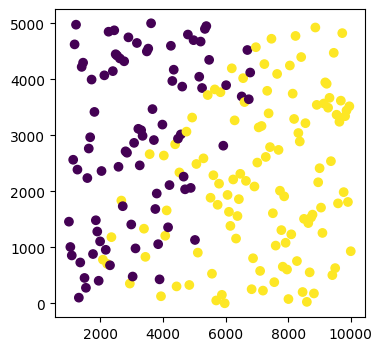

In [50]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x[:,0],x[:,1], c = y)

Split dataset

In [51]:
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.40, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

print(f"x_train.shape - {x_train.shape}, y_train.shape - {y_train.shape} \
      \nx_val.shape - {x_val.shape}, y_val.shape - {y_val.shape} \
      \nx_test.shape - {x_test.shape}, y_test.shape - {y_test.shape}")

x_train.shape - (120, 2), y_train.shape - (120,)       
x_val.shape - (40, 2), y_val.shape - (40,)       
x_test.shape - (40, 2), y_test.shape - (40,)


Scaling

In [52]:
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

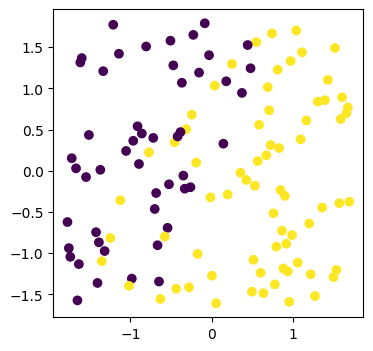

In [53]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x_train_scaled[:,0],x_train_scaled[:,1], c = y_train)

Tensorflow 3 NN models

In [54]:
models = build_models(input_shape=(2,))
models_qty = len(models)

error_models = np.zeros(models_qty)

for i in range(models_qty):

    model = models[i]

    model.compile(
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    )

    history = model.fit(x_train_scaled, y_train,
              epochs=200,
              verbose=0)

    prediction = model.predict(x_val_scaled)
    prediction_sigmoid = tf.nn.sigmoid(prediction)
    bin_prediction = np.where(prediction_sigmoid >= 0.5, 1, 0).reshape(len(y_val),)
    error_models[i] = np.mean(y_val != bin_prediction)


2/2 [==============================] - 0s 4ms/step


In [55]:
best_model_idx = np.argmin(error_models)
print(f"Errors for 3 models = {error_models}, therefore best model index = {best_model_idx+1}")

Errors for 3 models = [0.125 0.125 0.15 ], therefore best model = 1


Testing model

In [57]:
prediction = models[best_model_idx].predict(x_test_scaled)
prediction = tf.nn.sigmoid(prediction)
prediction = np.where(prediction >= 0.5, 1, 0).reshape(len(y_test))
test_error = np.mean(prediction != y_test)
print(f"Classification best NN model - test error - {test_error}")

2/2 [==============================] - 0s 5ms/step
Classification best NN model - test error - 0.175


# Summary

| Model | Method | Comment | Valuation MSE | Test MSE |
| --- | --- | --- | --- | --- |
| Numpy - Linear Regression | LinearRegression() |  | 311.88 | 445.2 |
| Numpy - Polynomial Regression | Poly + LinearRegression() | Best fit polynom = 2 | [11589.56, 311.87, 44.20, 44.58, 45.74, 49.23, 61.358, 61.119, 80.769, 73.35] | 98.38 |
| Tensorflow - Regression | loss = MSE, optimizer = Adam, epochs = 300 | 3rd model best fit | [311.88, 311.88,  74.38] | 28.8 |
| Tensorflow - Bin Classification | loss = BinCrossEntropy, optimizer = Adam, epochs = 200 | 1st model best fit | [0.125 0.125 0.15 ] | 0.175 |

# Indicators of a good model:

* High test error & high validation error - underfitting
* Low test error & much higher validation error - overfitting
* Low test error & low validation error - good fit

<center>  <img  src="./images/C2_W3_indicators_issue_in_model.png" width="600" />  